# Face Recognition

### !!This is a basic notebook, completing which you can get (preliminarly) 5/10 ponints. Other tasks which will get you more ponts are describes in a Slack channel.

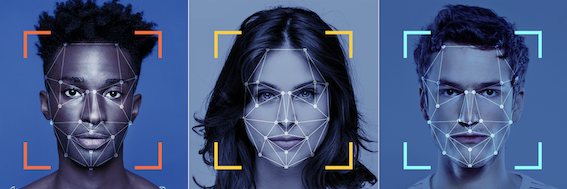

In this project you'll dive into face recognition framework and train neural network for face recognition task, play with losses and metrics.

We will train neural network on [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). 

As you see on the site, images of celebA dataset look like this:


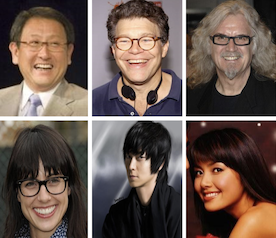

But we won't train a neural network for face recognition on those images. We'll need to preprocess them first. Let's see why we need it and how we need to preprocess them.

Let's look at how face recognition systems work:

## Face recognition model training and inference setup

This section describes how face recognition models are trained, what data alignment is and how the inference of face recognition model looks like. If you are familiar with this, you can skip this section.

### Model training

To train face recognition model on any facial dataset images must be aligned first. This step is very important to achieve a good quality of face recognition.

What is alignment: it consists of three steps:
1. Given image, identify facial landmarks on the image (coordinates of eyes, nose and mouth points). Separate neural network can be used there which was trained to identify landmarks on facial images. You can refer to [PyTorch Landmarks tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) to see how this works.
2. Rotate all the images in the dataset so that eyes of the person on every image lie on a certain pre-defined horizontal line.
3. Scale all the images in the dataset so that the size of the faces are approximately identical.

Here's an example of what we would get after alignment of all the images of Aaron Peirsol from our dataset:

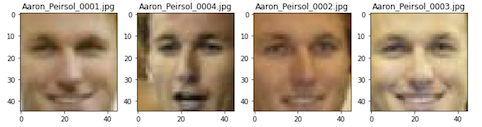

You see that eyes of all the faces lie on one horizontal line and all the faces have almost the same size. If we align all the images in the dataset, we can then train a neural network on aligned images.

**Why we need the alignment procedure**: the alignment of all faces in dataset makes the task of facial recognition easier for the model. If all the faces that model sees are of the same size and have their landmarks (eyes, nose, etc) on almost the same parts of the images, it is easier for the model to learn to identify a person on the image. The model diesn't need to "search" for the face and eyes positions on the image befire performing a recognition.

If you are interested, you can also train a model on non-aligned images, but you'll see that it would perform badly. It is possible though to train a model for face recognition without pre-alignment of all the faces, but this would require a huge amount of data — more that almost any company has. The only company that has openly presented its face recognition system that does not require special alignment is Facebook — their neural network was trained on a really huge amount of data using a special trick to avoid alignment. You can read more details [here](https://research.fb.com/publications/deepface-closing-the-gap-to-human-level-performance-in-face-verification/)

### Model inference

So let's see how the model trained on aligned faces can be used in real world:

Let's assume you owe a company and you want to build a face recognition system for your working office. You decided to hang some cameras around the office and want them to be able to recognize faces of all your employees when they are sitting / walking around the office (we let you decide by yourself why you would need such a system in your office)


A system for face recognition typically conststs of 3 stages:
- face detection
- face alignment
- face recognition

Let's discuss them in detail:

**Face detection**

When the camera is hanged on the wall it records a video and splits the video into single images, like this:

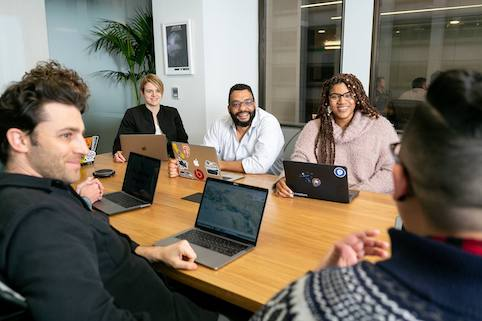

To be able to recognize all the faces on the photo you need first to detect all the faces that are present on the photo, like this:

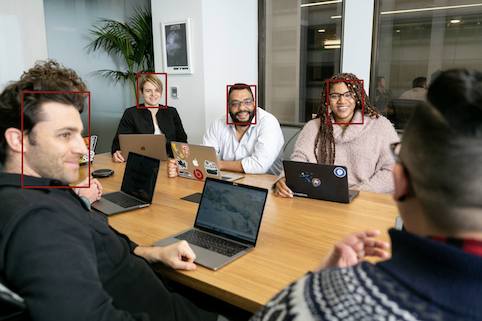

That is the first part — detection. You could use any neural network that can detect humans for this.

**Face alignment**

The second stage is to align all the faces found. The alignment procedure here should be the same as used to align training images.

So we'll get an image of a guy on a photo aligned like this:

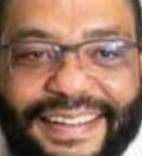

**Face recognition**

On the third stage we use the neural network that we trained to recognize a face.

So that's how the face recognition models pipeline work. You can also read about it more on [this link](https://www.nytimes.com/wirecutter/blog/how-facial-recognition-works/) (and using internet search)

## Neural network model architecture 

Let's discuss how model for face recognition should look like.



The easiest and, actually, the most used way to build a neural network for face recognition is to build it as a **simple classifier**.

Assume we have a dataset with photos of N different people. Then we can build a neural network to classify all the images from the dataset into N classes. Each class refers to one unique person in the dataset.

**How do we recognize new people by this network then?** We actually want the network for face recognition to be able to recognize not only the people which are in training set, but almost every person in the world.

That is how: after training the model, we'll drop it's last classification layer. After that when we'll pass an image of the person through network, we'll get the output of the pre-last layer — it's **the embedding of the image**. Having embeddings of two different images we can compare them using **cosine distance**. The less the distance is — the higher the probability that those two photos belong to one person is. 

Using that technique we can get embeddings of every image — even of unseen people, compare them, and reveal images belonging to same people. 

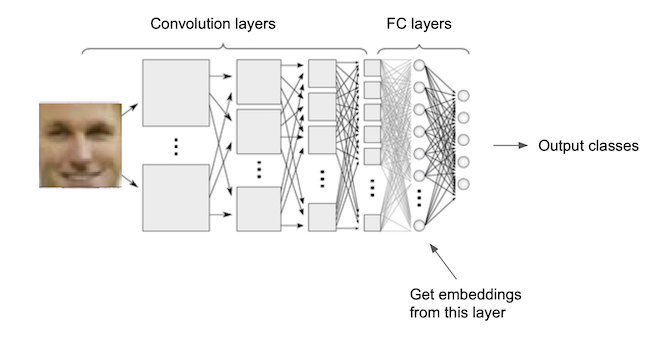

## Task 1 (30% points): build a neural network for faces classification as discribed above.

### Dataset 

We will train out face recognition network on part of the [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). But we'll use a version of it that has all the images in it aligned and cropped. You can download the dataset using this link: https://disk.yandex.ru/d/S8f03spLIA1wrw

In [1]:
# this link won't work for you, if you want to generate working link, 
# visit https://askubuntu.com/questions/1188381/how-to-get-link-of-file-to-download-with-wget
# or download the data and place it to folder manually
# ! wget "D://" -O celebA_train_500.zip
# ! unzip celebA_train_500.zip

Let's look at the data first:

In [2]:
# ! ls celebA_train_500/

- celebA_imgs — folder with aligned images 
- celebA_anno.txt — file with annotations: which person each image corresponds to
- celebA_train_split.txt — file with train/val/test info

In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from skimage import io, transform
import torch.nn as nn
import torch
import pandas as pd
from tqdm import tqdm
from functools import reduce
import operator
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from facenet_pytorch import InceptionResnetV1, training
from sklearn.metrics import accuracy_score, f1_score
import face_recognition
import pandas as pd
import seaborn as sns
from itertools import combinations, product
from collections import Counter
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from itertools import combinations, product
from random import sample, choice
from sys import maxsize
from torch.optim import Adam, SGD, lr_scheduler
import math

from catalyst.data import InBatchTripletsSampler

import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

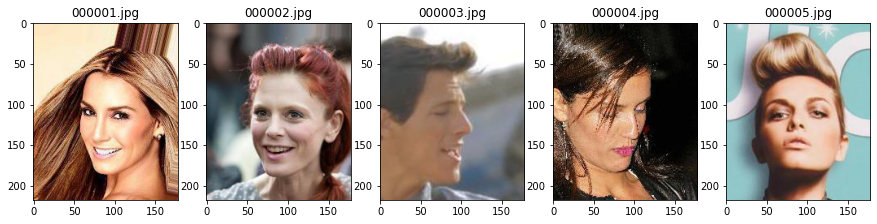

In [4]:
def show_imgs(images_names):
    imgs = []
    for img in images_names:
        img = Image.open(os.path.join('D:/celebA_train_1k/celebA_imgs/', img))
        imgs.append(np.array(img))

    f, axes= plt.subplots(1, len(imgs), figsize=(3*len(imgs),5))
    for i, axis in enumerate(axes):
        axes[i].imshow(imgs[i], cmap='gray')
        axes[i].set_title(images_names[i])
    plt.show()

images_names = os.listdir('D:/celebA_train_1k/celebA_imgs/')[:5]
show_imgs(images_names)


### Train Neural Network

Let's build a Datasets and network using this images:

In [5]:


def get_paths(dataset_type='train'):
    '''
    a function that returnes list of images paths for a given type of the dataset
    params:
      dataset_type: one of 'train', 'val', 'test'
    '''

    labels_dict = {
        'train': 0,
        'val': 1,
        'test': 2,
    }

    f = open('D:/celebA_train_1k/celebA_train_split.txt', 'r')
    lines = f.readlines()
    f.close()

    lines = [x.strip().split() for x in lines]
    lines = [x[0] for x in lines if int(x[1]) == labels_dict[dataset_type]]

    images_paths = []
    for filename in lines:            
        images_paths.append(os.path.join('D:/celebA_train_500/celebA_imgs/', filename))
    
    return np.array(images_paths)


class celebADataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, dataset_type, transform, aug=None,):
        self.images = get_paths(dataset_type=dataset_type)

        f = open('D:/celebA_train_1k/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        labels = [x.strip().split() for x in labels]
        labels = {x:y for x, y in labels}
        self.labels = [labels[x.split('/')[-1]] for x in self.images]

        self.transform = transform
        self.aug = aug
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        img_name = self.images[idx]
        label = self.labels[idx]
        
        image = Image.open(img_name) 
        
        if self.aug:
            sample = self.aug(
                image=image,
            )
        else:
            sample = {
                'image': image,
                'label': label,
            }
        
        sample['image'] = self.transform(sample['image'])

        return sample

In [6]:
transform = transforms.Compose([
      # you may add anything, e.g. augmentation
      transforms.Resize(160),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_data = celebADataset('train', transform)
val_data = celebADataset('val', transform)
test_data = celebADataset('test', transform)

# choose your own batch_size
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

We'll use pretrained on VGGFace2 network InceptionResnetV1 from here: https://github.com/timesler/facenet-pytorch/tree/master/models

In [7]:
# ! git clone https://github.com/timesler/facenet-pytorch.git
# ! mv facenet-pytorch/models ./

In [8]:
# ! ls models

In [9]:
# ! pip install facenet-pytorch

In [10]:
# def weights(model):
#     for i in model.modules():
#         if isinstance(i, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
#             nn.init.normal_(i.weight.data, 0.0, 0.02)

In [11]:
df_ann = pd.read_csv('D:/celebA_train_1k/celebA_anno.txt', sep=' ')
df_ann.columns = ['name', 'label']
labels = df_ann['label'].value_counts().index.to_list()
labels = sorted(labels)
labels_count = len(labels) # Count of classes

In [12]:
labels_count

1000

In [13]:
# from facenet_pytorch import InceptionResnetV1, training, fixed_image_standardization
# from models import inception_resnet_v1
model = InceptionResnetV1(pretrained='vggface2', num_classes = labels_count, classify=True, device=device)

**Workflow**: fine-tune a model on train_data using val_data for validation.Use standard CE loss.  Calculate the loss and accuracy on test set after training. 

You may use any optimizer you want and any learning rate. It is also beneficial to freeze starting layers to boost training speed and avoid overfitting. 


**To get the whole mark for this section you need to achieve 80% accuracy on test set**.

In [14]:
# Let's look how many children

children = 0

for child in model.children():
    print(f'Child {children} is:')
    print(child)
    children += 1
print(f'There are {children} children')



Child 0 is:
BasicConv2d(
  (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
)
Child 1 is:
BasicConv2d(
  (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
)
Child 2 is:
BasicConv2d(
  (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
)
Child 3 is:
MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
Child 4 is:
BasicConv2d(
  (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
)
Child 5 is:
BasicConv2d(
  (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 

In [15]:
print(f'There are {children} children')

There are 18 children


In [16]:
# Freezing layers
kids_to_freeze = [x for x in range(12)]
for i, child in enumerate(model.children()):
    if i in kids_to_freeze:
        for param in child.parameters():
            param.requires_grad = False


In [17]:
# # Get output pre_last layer

# in_features = list(model.children())[-1].in_features
# in_features

In [18]:
# Drop last layer

# model = torch.nn.Sequential(*(list(model.children())[:-1]))

In [19]:
# model.fc = nn.Linear(in_features, labels_count)
# face_model = model.to(device)
# face_model

In [18]:
face_model = model
face_model

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [21]:
epochs = 11
lr = 0.0001
opt = torch.optim.Adam(model.parameters(), lr = lr, )
criterion = nn.CrossEntropyLoss()

In [22]:
history = []

for epoch in tqdm(range(epochs)):
    
    # Training
    train_loss = []
    train_corrects = 0
    train_counter = 0
    face_model.train()
    
    for data_trn in train_loader:
        data =  data_trn['image'].to(device)
        labels = torch.tensor(list(map(int, data_trn['label']))).to(device)
        opt.zero_grad()
        result = face_model(data)
        loss = criterion(result, labels)
        loss.backward()
        opt.step()
        preds = torch.argmax(result, 1)
        train_loss.append(loss.detach().cpu())
        train_corrects += torch.sum(preds == labels.data)
        train_counter += data.size(0)
#         print(f'loss:  {loss}, corrects: {train_corrects}, counter: {train_counter} , idx : {idx_trn}')
    train_LOSS = np.mean(train_loss)
    train_ACC = train_corrects.cpu().numpy() / train_counter
    
    # Testing
    
    test_loss = []
    test_corrects = 0
    test_counter = 0    
    face_model.eval()
    
    for  data_test in val_loader:
        data_ = data_test['image'].to(device)
        labels_ = torch.tensor(list(map(int, data_test['label']))).to(device)
        with torch.set_grad_enabled(False):
            outputs_ = face_model(data_)
            loss_ = criterion(outputs_, labels_)
            preds_ = torch.argmax(outputs_, 1)
            test_loss.append(loss_.detach().cpu())
            test_corrects += torch.sum(preds_ == labels_.data)
            test_counter += data_.size(0)
#             print(f'test_loss:  {loss_}, test_corrects: {test_corrects}, test_counter: {test_counter} , test_idx : {idx_test}')
        
    test_LOSS = np.mean(test_loss)
    test_ACC = test_corrects.cpu().numpy() / test_counter        
    print(f'train_loss {train_LOSS}, train_ACC {train_ACC}')  
    print(f'test_loss {test_LOSS}, test_ACC {test_ACC}')  
    history.append((train_LOSS, train_ACC, test_LOSS, test_ACC))

  9%|███████▌                                                                           | 1/11 [01:19<13:11, 79.11s/it]

train_loss 5.9232563972473145, train_ACC 0.15888015025237703
test_loss 4.689451217651367, test_ACC 0.5002676659528907


 18%|███████████████                                                                    | 2/11 [02:35<11:36, 77.44s/it]

train_loss 3.9248504638671875, train_ACC 0.6070548186406856
test_loss 3.0975096225738525, test_ACC 0.7518736616702355


 27%|██████████████████████▋                                                            | 3/11 [03:51<10:14, 76.78s/it]

train_loss 2.5329627990722656, train_ACC 0.8066674492311304
test_loss 2.1107468605041504, test_ACC 0.8439507494646681


 36%|██████████████████████████████▏                                                    | 4/11 [05:07<08:56, 76.67s/it]

train_loss 1.611335277557373, train_ACC 0.895586336424463
test_loss 1.4331722259521484, test_ACC 0.8846359743040685


 45%|█████████████████████████████████████▋                                             | 5/11 [06:23<07:38, 76.46s/it]

train_loss 1.0315470695495605, train_ACC 0.9390186641624604
test_loss 1.4240041971206665, test_ACC 0.8656316916488223


 55%|█████████████████████████████████████████████▎                                     | 6/11 [07:40<06:21, 76.35s/it]

train_loss 0.659023642539978, train_ACC 0.966017138161756
test_loss 0.858446478843689, test_ACC 0.9164882226980728


 64%|████████████████████████████████████████████████████▊                              | 7/11 [08:56<05:05, 76.49s/it]

train_loss 0.4313647150993347, train_ACC 0.9782251437962202
test_loss 0.7442678213119507, test_ACC 0.9229122055674518


 73%|████████████████████████████████████████████████████████████▎                      | 8/11 [10:13<03:49, 76.45s/it]

train_loss 0.2969367206096649, train_ACC 0.9866181476699143
test_loss 0.6688376665115356, test_ACC 0.9215738758029979


 82%|███████████████████████████████████████████████████████████████████▉               | 9/11 [11:29<02:32, 76.40s/it]

train_loss 0.20788094401359558, train_ACC 0.9919591501349924
test_loss 0.7760443091392517, test_ACC 0.8907922912205567


 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [12:45<01:16, 76.38s/it]

train_loss 0.14603084325790405, train_ACC 0.9965958445826975
test_loss 0.5640877485275269, test_ACC 0.9247858672376874


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [14:02<00:00, 76.60s/it]

train_loss 0.11773893237113953, train_ACC 0.9968893062566029
test_loss 0.5386530160903931, test_ACC 0.9237152034261242


In [23]:
# torch.save(face_model, './face_model_trained')
# np.save('./history.npy', history)

In [19]:
face_model = torch.load('./face_model_trained')
history = list(np.load('./history.npy'))

In [11]:
history

[array([5.9232564 , 0.15888015, 4.68945122, 0.50026767]),
 array([3.92485046, 0.60705482, 3.09750962, 0.75187366]),
 array([2.5329628 , 0.80666745, 2.11074686, 0.84395075]),
 array([1.61133528, 0.89558634, 1.43317223, 0.88463597]),
 array([1.03154707, 0.93901866, 1.4240042 , 0.86563169]),
 array([0.65902364, 0.96601714, 0.85844648, 0.91648822]),
 array([0.43136472, 0.97822514, 0.74426782, 0.92291221]),
 array([0.29693672, 0.98661815, 0.66883767, 0.92157388]),
 array([0.20788094, 0.99195915, 0.77604431, 0.89079229]),
 array([0.14603084, 0.99659584, 0.56408775, 0.92478587]),
 array([0.11773893, 0.99688931, 0.53865302, 0.9237152 ])]

In [12]:
 tr_loss,tr_acc, val_loss, val_acc=zip(*history)

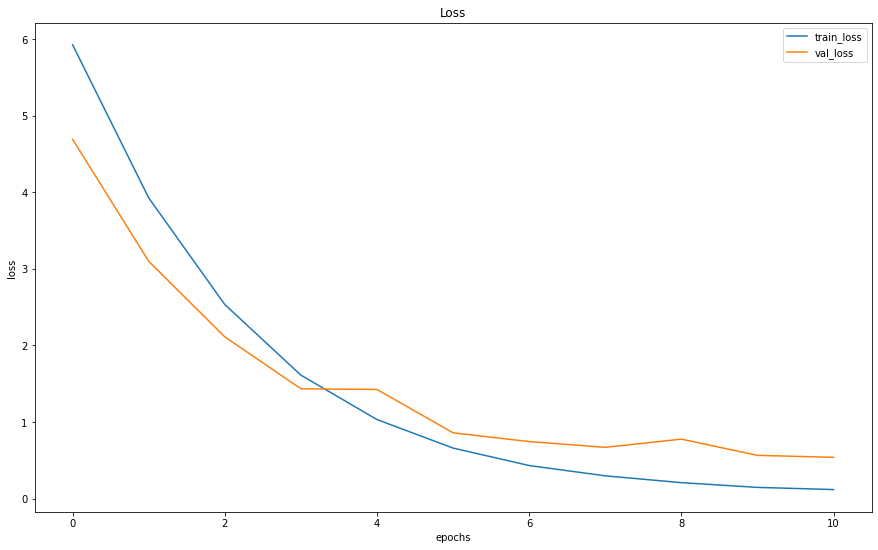

In [13]:
plt.figure(figsize=(15, 9))
plt.plot(tr_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.title('Loss')
plt.ylabel("loss")
plt.show()

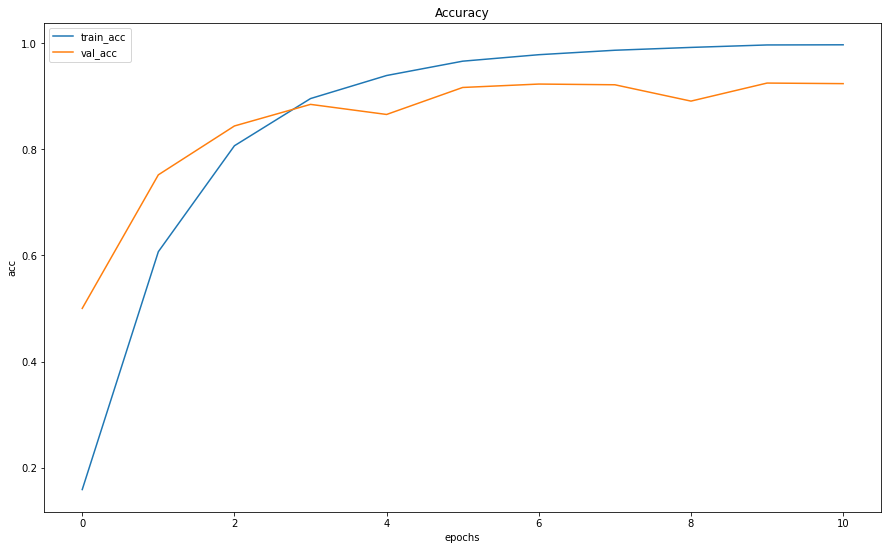

In [14]:
plt.figure(figsize=(15, 9))
plt.plot(tr_acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.title('Accuracy')
plt.show()

In [29]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs['image'].to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [30]:
probs_ims = predict(face_model, test_loader)
y_pred = np.argmax(probs_ims,-1)

In [31]:
actual_labels = []
for i in test_loader:
    actual_labels.append(i['label'])

In [32]:
actual_labels = reduce(operator.concat,actual_labels)
actual_labels_ = [int(x) for x in actual_labels]

In [33]:
print(f'Accuracy on test: {accuracy_score(actual_labels_, y_pred.tolist())}')

Accuracy on test: 0.9152488972904852


**Cosine similarity calculation**: drop a last layer of trained network. Get embeddings for some images from train set and for images from test set. Calculate cosine similarities between embeddings corresponding to the pictures of the same person and different people. Is the difference big in any of cases?

In [20]:
cropped_model = torch.nn.Sequential(*(list(face_model.children())[:-5]))

In [21]:
cropped_model

Sequential(
  (0): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (1): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (2): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (5): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3,

**Cosine similarity distribution**: calculate all the cosine similarities between images in test dataset and train dataset of the same person. This means if you have image of person #106 in test dataset, calculate all similarities between this person's embeddings from test dataset and this person's embeddings from train dataset. 

Then also do that for pairs of different people. This means if you have image of person #106 in test dataset, calculate similarities between this person's embeddings from test dataset and other people embeddings from train dataset. 

This calculation may take a long time and memory since it's a lot of pairs. You can cut the number of pairs which you calculate distances between up to 5k, as an example.

In [35]:
# temp_test = list(test_data)
# temp_train = list(train_data)

In [36]:
# test_labels = [int(x['label']) for x in temp_test]
# unique_test_labels = sorted(list(set(test_labels)))

In [37]:
# test_labels_dict = {x:[y for y in range(test_labels.index(x), test_labels.index(x) + test_labels.count(x))] for x in unique_test_labels}

In [38]:
# train_labels = [int(x['label']) for x in temp_train]
# unique_train_labels = sorted(list(set(train_labels)))

In [39]:
# train_labels_dict = {x:[y for y in range(train_labels.index(x), train_labels.index(x) + train_labels.count(x))] for x in unique_train_labels}

In [40]:
# del temp_test, temp_train, test_labels, unique_test_labels, train_labels, unique_train_labels

In [64]:
def get_embeddings(model, loader):
    
    # Finding mean embedding vector for each person
    model.eval()
    with torch.no_grad():
        d = {}  # Dict  
        for inputs in tqdm(loader):
            data = inputs['image'].to(device) #64 imgs
            labels = list(map(int,inputs['label'])) # 64 lbls
            
            
            outputs = model(data).cpu() 
            tuples = list(zip(labels, outputs)) # tuple (label, output)            
            
            # Making dict with embeddings
            for item in tuples:
                if item[0] in list(d.keys()):
                    d[item[0]].append(item[1].flatten())
                else:
                    d.update({item[0]: [item[1].flatten()]})
            torch.cuda.empty_cache()
                    
        # Mean embedding for each person            
        for key in d.keys():
            d[key] = sum(d[key]) / len(d[key])
            
    return d

In [37]:
test_embeddings = get_embeddings(cropped_model, test_loader)
train_embeddings = get_embeddings(cropped_model, train_loader)

100%|████████████████████████████████████████████████████████████████████████████████| 267/267 [01:05<00:00,  4.05it/s]


In [38]:
set(train_embeddings.keys()) - set(test_embeddings.keys())

{20,
 245,
 258,
 259,
 289,
 326,
 355,
 406,
 465,
 500,
 503,
 555,
 567,
 591,
 596,
 639,
 645,
 747,
 783,
 810,
 847,
 899,
 903,
 965}

Sets not equal. Take only intersection

In [39]:
persons = set(train_embeddings.keys()) & set(test_embeddings.keys()) 
n_persons = len(set(train_embeddings.keys()) & set(test_embeddings.keys()) )

In [40]:
cosines_lst = []
for person_a in tqdm(persons) :
    for person_b in persons:
        cosine = nn.functional.cosine_similarity(test_embeddings[person_a],train_embeddings[person_b], dim=0)
        cosines_lst.append(cosine)


100%|████████████████████████████████████████████████████████████████████████████████| 976/976 [01:58<00:00,  8.25it/s]


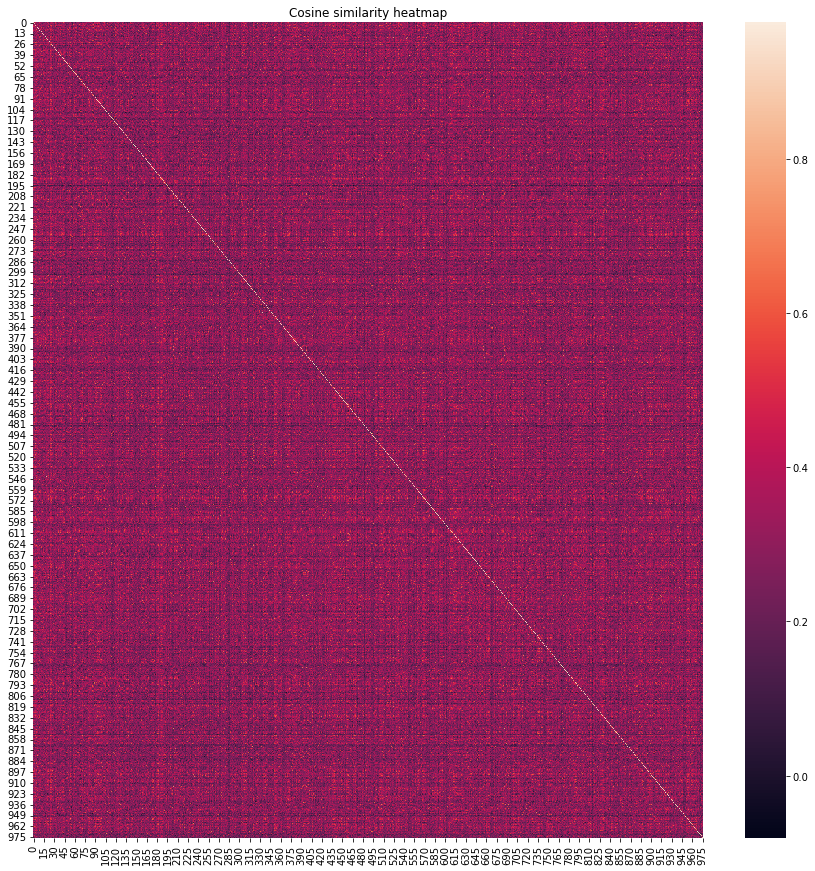

In [41]:
plt.figure(figsize=(15,15))
sns.heatmap(torch.Tensor(cosines_lst).reshape(n_persons, n_persons))
plt.title('Cosine similarity heatmap');

## Task 2 (20% points): Identificaton rate metric

When training the model above we used CE loss on val and test set as a measure of performance of our model. But this has a major disadvantage: we can't measure how godd a model would work on unseen faces (which are not present in training, val & test sets)

To address this we can calculate another metric for the model: **identification rate**. This is how it works:

We have two sets of faces: query and distractors. None of the faces from those sets are present in train, val or test sets.

1. calculate cosine similarities between all the faces corresponding to the same people from query dataset. This means if the person has 3 photos in query part: 01.jpg, 02.jpg, 03.jpg, then calculate 3 cosine similarities between every pair of embeddings corresponding to those photos. 
2. calculate cosine similarities between all the faces corresponding to the different people from query dataset. 
3. calculate cosine similarities between all the pairs of embeddings corresponding to query and distractors. This means calculate similarities between pairs (q, d), where q is the embedding that corresponds to a face from query, d — embedding that corresponds to a face from distractors. You'll get |query|*|distractors| similarities.
4. Sum numbers of similarities from 2 and 3 stages. This is a number of false pairs.
5. fix **FPR** (false positive rate). Let it be 0.01 in our case. FPR multiplied by a number of false pairs from the stage 4 is the number of false positives we would allow our model to make. Let's call this number N
6. Sort all the similarities of false pairs by descending order. Get the Nth element from the beginning — that's our **threshold similarity**.
7. Calculate how many positive similarities from stage 1 are equal or more that threshold. Divide this number by whole number of positive similarities from stage 1. This is TPR (true positive rate) — our metric.

This metric can also be expressed as TPR@FPR=0.01. FPR can vary. 

Datasets (query photos, query labels & distructors photos) you can download from here: https://disk.yandex.ru/d/C54mClLmQkag6Q

**Task**: implement the TPR@FPR metric. Calculate it for your model and test dataset on FPR=[0.5, 0.2, 0.1, 0.05].

There're some functions pre-defined and some tests given for better understanding. Please don't change the functions prototypes, so that you can use asserts for checking.

In [18]:
from collections import defaultdict

# file with query part annotations: which image belongs to which class
# format: 
#     image_name_1.jpg 2678
#     image_name_2.jpg 2679
f = open('D:/celebA_ir/celebA_anno_query.txt', 'r')
query_lines = f.readlines()
f.close()
query_lines = [x.strip().split() for x in query_lines]
# plain list of image names from query. Neede to compute embeddings for query
query_img_names = [x[0] for x in query_lines]
# dictionary with info of which images from query belong to which class
# format:
#     {class: [image_1, image_2, ...]}
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
    query_dict[img_class].append(img_name)
# list of distractor images
distractors_img_names = os.listdir('D:/celebA_ir/celebA_distractors') 

In [13]:
def compute_embeddings(model, images_list, kind='query'):
    
    '''  compute embeddings from the trained model for list of images.
  params:
    model: trained nn model that takes images and outputs embeddings
    images_list: list of images paths to compute embeddings for
  output:
    list: list of model embeddings. Each embedding corresponds to images 
          names from images_list      '''
    
    if kind == 'query':
        root = 'D:/celebA_ir/celebA_query/'
    elif kind =='distractor':
        root = 'D:/celebA_ir/celebA_distractors/'
    
    model.eval()
    with torch.no_grad():
        embeddings = []
        for name in tqdm(images_list):
            img = Image.open(os.path.join(root, name))
            output = model(transform(img).to(device).unsqueeze(0))
            embeddings.append(output.flatten().cpu().numpy())
            torch.cuda.empty_cache()
            
    return embeddings     
            
    
    
    raise NotImplementedError

In [44]:
# query_embeddings = compute_embeddings(cropped_model, query_img_names)
# distractors_embeddings = compute_embeddings(cropped_model, distractors_img_names, kind='distractor')

100%|████████████████████████████████████████████████████████████████████████████| 23397/23397 [17:29<00:00, 22.30it/s]


In [45]:
# np.save('D:/distractors_embeddings.npy', np.array(distractors_embeddings),)
# np.save('D:/query_embeddings.npy', np.array(query_embeddings),)

In [48]:
distractors_embeddings = np.array(np.load('D:/distractors_embeddings.npy', allow_pickle=True))
query_embeddings = np.array(np.load('D:/query_embeddings.npy', allow_pickle=True))



In [49]:
from itertools import combinations
from collections import Counter

In [50]:
def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
    '''compute cosine similarities between positive pairs from query (stage 1)
          params:
            query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in 
                        the dataset. Value: images corresponding to that class
            query_img_names: list of images names
            query_embeddings: list of embeddings corresponding to query_img_names
          output:
            list of floats: similarities between embeddings corresponding 
                            to the same people from query list'''
    query_embeddings = torch.Tensor(query_embeddings) 
      
    lst = []
    for key in tqdm(query_dict.keys()):

        combs = list(combinations(query_dict[key],2))
        get_cos = nn.functional.cosine_similarity
        get_index = query_img_names.index
        
        lst.append([get_cos(query_embeddings[get_index(x[0])], query_embeddings[get_index(x[1])], dim=0) for x in combs])
    lst = list(map(float, [item for sublist in lst for item in sublist]))
    return np.array(lst)
    
    raise NotImplementedError

In [51]:
def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
    
  
    '''compute cosine similarities between negative pairs from query (stage 2)
    params:
      query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in 
                  the dataset. Value: images corresponding to that class
      query_img_names: list of images names
      query_embeddings: list of embeddings corresponding to query_img_names
    output:
      list of floats: similarities between embeddings corresponding 
                    to different people from query list
    '''
    query_embeddings = torch.Tensor(query_embeddings)
    keys = list(query_dict.keys())
    lst = list()
    

    combs = [list(product(query_dict[keys[x-1]], query_dict[keys[x-2]])) for x, i  in enumerate(keys,start=1)]        
    combs = [item for sublist in combs for item in sublist]
    get_cos = nn.functional.cosine_similarity
    get_index = query_img_names.index
    print(f'Combinations count {len(combs)}')
    lst.append([get_cos(query_embeddings[get_index(x[0])], query_embeddings[get_index(x[1])], dim=0) for x in tqdm(combs) ])
        
    lst = list(map(float, [item for sublist in lst for item in sublist]))
    return np.array(lst)  

In [52]:
def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
    ''' compute cosine similarities between negative pairs from query and distractors
      (stage 3)
      params:
        query_embeddings: list of embeddings corresponding to query_img_names
        distractors_embeddings: list of embeddings corresponding to distractors_img_names
      output:
        list of floats: similarities between pairs of people (q, d), where q is 
                        embedding corresponding to photo from query, d —
                        embedding corresponding to photo from distractors   '''
    
    return cosine_similarity(query_embeddings, distractors_embeddings).reshape(1, -1)[0]
            
    raise NotImplementedError

In [53]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names, 
                                            query_embeddings)



100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:26<00:00, 11.47it/s]


In [54]:
cosine_query_neg = compute_cosine_query_neg( query_dict, query_img_names, 
                                            query_embeddings)


Combinations count 172439


100%|████████████████████████████████████████████████████████████████████████| 172439/172439 [00:52<00:00, 3293.90it/s]


In [55]:
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings, 
                                                            distractors_embeddings)

Check you code of functions which compute similarities:

In [56]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = [
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
]

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = [
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
]

test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names, 
                                            test_query_embeddings)
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names, 
                                            test_query_embeddings)
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings, 
                                                            test_distractors_embeddings)

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 601.65it/s]


Combinations count 11


100%|███████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11024.45it/s]


In [57]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

Implement the final function: identification rate calculation

In [58]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, 
               fpr=0.1):
    '''
      compute identification rate using precomputer cosine similarities between pairs
      at given fpr
      params:
        cosine_query_pos: cosine similarities between positive pairs from query
        cosine_query_neg: cosine similarities between negative pairs from query
        cosine_query_distractors: cosine similarities between negative pairs 
                                  from query and distractors
        fpr: false positive rate at which to compute TPR
      output: 
        float: threshold for given fpr 
        float: TPR at given FPR '''
    
    
  
    tn =  len(cosine_query_neg) + len(cosine_query_distractors) # count of false pairs
    N = round(fpr * tn) 
    treshold = np.sort(np.hstack((cosine_query_neg, cosine_query_distractors)), kind='quicksort')[::-1][N]
    mask = cosine_query_pos >= treshold
    above_treshold = len(cosine_query_pos[mask]) 
    tpr = above_treshold / len(cosine_query_pos)
    
    return treshold, tpr

Check yourself:

In [59]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
    
    x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg, 
                    test_cosine_query_distractors, fpr=fpr)
    test_thr.append(x)
    test_tpr.append(y)

In [60]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

Finally compute tpr for faces query and distractors dataset and fpr = [0.5, 0.2, 0.1, 0.05]:

In [61]:
thr = []
tpr = []
for fpr in tqdm([0.5, 0.2, 0.1, 0.05]):
    
    x, y = compute_ir(cosine_query_pos, cosine_query_neg, 
                    cosine_query_distractors, fpr=fpr)
    thr.append(x)
    tpr.append(y)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:23<00:00, 20.84s/it]


In [62]:
thr
 

[0.2118951976299286,
 0.29156023263931274,
 0.3361929655075073,
 0.3738708794116974]

In [63]:
tpr

[0.9801690799532332, 0.941103066822556, 0.9015424048925264, 0.8527970141199748]

## Task 3 (50% points): Loss functions

Building a network on task 1 we used an ordinary CE loss. But there are many more variants of loss functions that can be used to train neural network. We will discuss two of them, which are the most popular. More examples of losses for face recognition and their performance reviews you can find in this paper: https://arxiv.org/pdf/1901.05903.pdf

### TripletLoss (25% points)

This is another kind of loss which does not require a model to have last classification layer — it works directly with embeddings. It requires by design to make embeddings of one person be close on embeddings space and embeddings of different people be far away from each other. 

This loss has an advantage over CE-like losses: it does not rely on number of classes in dataset. If we have new faces of new people in a dataset, we won't need to completely retrain the network, we could just fine-tune the trained network on new photos.


**How TripletLoss works**:

Here the architecture of neural network will be slightly different than it was when we used CE loss: it won't have the last classification layer. The last layer of NN will output embeddings of the given photo. 

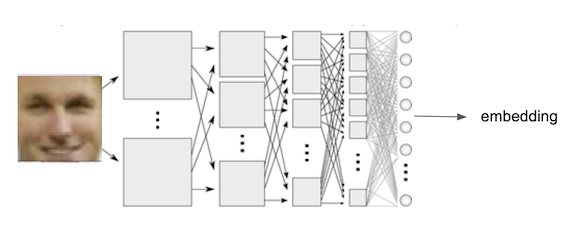

The TripletLoss function works directly with these embeddings. The idea of it is to make embeddings of the same people more close, compact in the embedding space, and the embeddings of the different people be more separate. There's a formula for the loss:

$$L(e, p, n) = max\{d(a, p) - d(a, n) + margin, 0\},$$

where 
- $e$ is embedding of a photo (output of a model)
- $p$ is a positive embedding for the photo (embedding that we want $e$ be close to)
- $n$ is a negative embedding for the photo (embedding that we want $e$ be far from)
- $d(x, y)$ is a distance measure between embeddings 
- margin — a positive margin to further boost the difference between $d(a, p)$ and $d(a, n)$

**All the embeddings $e$, $p$ and $n$ must be normalized before passing them to the loss**.

In our case for the given photo $E$ and it's embedding $e$ positive embedding $p$ must be an embedding of the photo of the same person and embedding $n$ must be an ambedding of the photo of the different person.

This emplementation of TripletLoss for PyTorch can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss). There are different variants of TripletLoss which can also boost performance and which you can implement by yourself, if you want:
- use more that 1 sample of $p$ and $n$ for one embedding $e$ 
- use special kinds of negatives: e.g. the negatives that are the most close to e (to boost them be further away from e)


**More to read about TripletLoss**:

The idea of TripletLoss: https://en.wikipedia.org/wiki/Triplet_loss

PyTorch implementation of TripletLoss: https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss

**Task**: implement a model and train it with TripletLoss. Play with margin parameter to achieve better results.

Which loss among which you have tried is the best?

**To get the full mark for this task you need to train a model using  TripletLoss correctly at least for one value of margin and achieve >=75% acc on test set.** 
As we don't have a classification layer in our network, we need a custom procedure for accuracy calculation. You can use one of the following procedures:
- calculate accuracy on val and test sets using KNN with embeddings from training set as training points. (easy way)
- compute mean embeddings for every class from training set and use them as reference embeddings. Then for every embedding v from val and test sets calculate cosine similarities between v and mean embeddings from train set. (the more "right" way, but requires code writing)

You can use any of those two variants.

**Hints**:
- think of what the distance function $d$ should be in our case: training a model we want it to output embeddings which can be compared using cosine similarity function. Pay attention to that cosine similarity is not a distance measure — the more cosine distance, the closer embeddings are. Think how you can put cosine distance into TripletLoss function.
- to train model using this loss you'll need to rewrite the Dataset class so it gives you not the random image and its label, but the image, positive images and negative images for this image;
- don't forget to normalize embeddings for the loss! You may even do that by adding batchnorm/layernorm to the last layer of your network

In [182]:
face_model = torch.load('./face_model_trained')
cropped_model = torch.nn.Sequential(*(list(face_model.children())[:-5]))
cropped_model.bn = nn.BatchNorm2d(1792)
cropped_model

Sequential(
  (0): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (1): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (2): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (5): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3,

In [183]:
for i, child in enumerate(cropped_model.children()):
    
    for param in child.parameters():
        print(i, param.requires_grad)

0 False
0 False
0 False
1 False
1 False
1 False
2 False
2 False
2 False
4 False
4 False
4 False
5 False
5 False
5 False
6 False
6 False
6 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
8 False
8 False
8 False
8 False
8 False
8 False
8 False


In [188]:
def get_paths(dataset_type='train'):
    '''
    a function that returnes list of images paths for a given type of the dataset
    params:
      dataset_type: one of 'train', 'val', 'test'
    '''

    labels_dict = {
        'train': 0,
        'val': 1,
        'test': 2,
    }

    f = open('D:/celebA_train_1k/celebA_train_split.txt', 'r')
    lines = f.readlines()
    f.close()

    lines = [x.strip().split() for x in lines]
    lines = [x[0] for x in lines if int(x[1]) == labels_dict[dataset_type]]

    images_paths = []
    for filename in lines:            
        images_paths.append(os.path.join('D:/celebA_train_500/celebA_imgs/', filename))
    
    return np.array(images_paths)


class celebADataset_triplet(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, dataset_type, transform, aug=None,):
        self.images = get_paths(dataset_type=dataset_type)

        f = open('D:/celebA_train_1k/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        labels = [x.strip().split() for x in labels]
        labels = {x:y for x, y in labels}        
        self.labels = np.array([labels[x.split('/')[-1]] for x in self.images])
        self.transform = transform
        self.aug = aug
        self.index = np.array([x for x in range(len(self.labels))])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):    
        
        anchor_img = self.images[idx]        
        anchor_label = self.labels[idx]
        positive_list = self.index[self.index!=idx][self.labels[self.index!=idx]==anchor_label]
        
        try:    
            positive_idx = choice(positive_list)
        except:
            positive_idx = idx
        positive_img = self.images[positive_idx]
        negative_list = self.index[self.index!=idx][self.labels[self.index!=idx]!=anchor_label]
        negative_idx = choice(negative_list)
        negative_img = self.images[negative_idx]
        
        anchor = self.transform(Image.open(anchor_img))
        positive = self.transform(Image.open(positive_img))
        negative = self.transform(Image.open(negative_img))
        
        if self.aug:
            sample = self.aug(
                image=image,
            )
        else:
            sample = {
                'anchor': anchor,
                'positive': positive,
                'negative':negative,
                'label':anchor_label
            }
            
        return sample
#         return anchor, positive, negative
            
    
    

In [198]:
transform = transforms.Compose([
      # you may add anything, e.g. augmentation
      transforms.Resize(160),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_data_triplet = celebADataset_triplet('train', transform)
val_data_triplet = celebADataset_triplet('val', transform)
test_data_triplet = celebADataset_triplet('test', transform)

# choose your own batch_size
batch_size = 64
train_loader_triplet = torch.utils.data.DataLoader(train_data_triplet, batch_size=batch_size, shuffle=True)
val_loader_triplet = torch.utils.data.DataLoader(val_data_triplet, batch_size=batch_size, shuffle=True)
test_loader_triplet = torch.utils.data.DataLoader(test_data_triplet, batch_size=batch_size, shuffle=False)

In [199]:
base_model = cropped_model.to(device)

In [65]:
train_embeddings = get_embeddings(base_model, train_loader) # mean embeddings for each person

100%|████████████████████████████████████████████████████████████████████████████████| 267/267 [01:03<00:00,  4.21it/s]


In [200]:
def train_triple(margin=0.5, epochs=5): 
    base_model = cropped_model.to(device)
    opt = Adam(base_model.parameters(), lr=0.001)
    criterion = nn.TripletMarginWithDistanceLoss(margin=margin, distance_function=lambda x, y: 1.0 - nn.functional.cosine_similarity(x, y))
    history = []

    for epoch in tqdm(range(epochs)):

        # Training
        train_loss = []
        base_model.train()
        for data_trn in train_loader_triplet:
            
            opt.zero_grad()
            labels = torch.tensor(list(map(int, data_trn['label']))).to(device)
            anchors_emb = base_model(data_trn['anchor'].to(device)).view(-1,1792*4*3)
            pos_emb = base_model(data_trn['positive'].to(device)).view(-1,1792*4*3)
            neg_emb = base_model(data_trn['negative'].to(device)).view(-1,1792*4*3)
#             true_embeddings = torch.tensor(np.array([np.array(train_embeddings[int(key)]) for key in data_trn['label']]))
            
            loss = criterion(anchors_emb, pos_emb, neg_emb)
            loss.backward()
            opt.step()
            train_loss.append(loss.detach().cpu())
        train_LOSS = np.mean(train_loss)
        print(f'Margin: {margin}  Epoch: {epoch}  Train_loss: {train_LOSS}')

        # Testing

        test_loss = []
        sum_correct = 0
        test_counter = 0
        base_model.eval()


        for  data_test in val_loader_triplet: 
            labels_ = torch.tensor(list(map(int, data_test['label']))).to(device)
            anchors_emb_ = base_model(data_test['anchor'].to(device)).view(-1,1792*4*3)            
            pos_emb_ = base_model(data_test['positive'].to(device)).view(-1,1792*4*3)
            neg_emb_ = base_model(data_test['negative'].to(device)).view(-1,1792*4*3)
            true_embeddings_ = torch.tensor(np.array([np.array(train_embeddings[int(key)]) for key in labels_]))
            with torch.set_grad_enabled(False):
                
                loss_ = criterion(anchors_emb_, pos_emb_, neg_emb_)
                cos_sims = cosine_similarity(anchors_emb_.cpu(), true_embeddings_)

                pred_idx = torch.argmax(torch.tensor(cos_sims), 1)
                pred = labels_[pred_idx]
                sum_correct += torch.sum(pred == labels_.data)                
                test_counter += len(labels_)
                test_loss.append(loss_.detach().cpu())
        test_LOSS = np.mean(test_loss)
        test_ACC = sum_correct.cpu().numpy() / test_counter   
        print(f'Margin: {margin}  Epoch: {epoch} Train_loss {train_LOSS} Test_loss: {test_LOSS}, Test_ACC: {test_ACC}')   
        
        history.append((train_LOSS, test_LOSS, test_ACC))
        
        torch.save(base_model, f'./triplet_margin_{margin}')
    return history

In [201]:
margins = np.linspace(0.1, 1, 4,)
report = dict.fromkeys(margins)

for margin in margins:
    report[margin] = train_triple(margin=margin, epochs=10)
    

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Margin: 0.1  Epoch: 0  Train_loss: 0.0015118764713406563


 10%|████████▏                                                                         | 1/10 [03:50<34:31, 230.21s/it]

Margin: 0.1  Epoch: 0 Train_loss 0.0015118764713406563 Test_loss: 0.0024535541888326406, Test_ACC: 0.8763383297644539
Margin: 0.1  Epoch: 1  Train_loss: 0.0015365806175395846


 20%|████████████████▍                                                                 | 2/10 [07:40<30:39, 229.97s/it]

Margin: 0.1  Epoch: 1 Train_loss 0.0015365806175395846 Test_loss: 0.0027842840645462275, Test_ACC: 0.857066381156317
Margin: 0.1  Epoch: 2  Train_loss: 0.0016128731658682227


 30%|████████████████████████▌                                                         | 3/10 [11:29<26:48, 229.77s/it]

Margin: 0.1  Epoch: 2 Train_loss 0.0016128731658682227 Test_loss: 0.0023573378566652536, Test_ACC: 0.8691113490364025
Margin: 0.1  Epoch: 3  Train_loss: 0.0014658323489129543


 40%|████████████████████████████████▊                                                 | 4/10 [15:18<22:57, 229.64s/it]

Margin: 0.1  Epoch: 3 Train_loss 0.0014658323489129543 Test_loss: 0.0033322027884423733, Test_ACC: 0.8099571734475375
Margin: 0.1  Epoch: 4  Train_loss: 0.001495060627348721


 50%|█████████████████████████████████████████                                         | 5/10 [19:08<19:07, 229.51s/it]

Margin: 0.1  Epoch: 4 Train_loss 0.001495060627348721 Test_loss: 0.0026574889197945595, Test_ACC: 0.8648286937901499
Margin: 0.1  Epoch: 5  Train_loss: 0.0014865968842059374


 60%|█████████████████████████████████████████████████▏                                | 6/10 [22:57<15:17, 229.33s/it]

Margin: 0.1  Epoch: 5 Train_loss 0.0014865968842059374 Test_loss: 0.003019393654540181, Test_ACC: 0.8675053533190579
Margin: 0.1  Epoch: 6  Train_loss: 0.0013963526580482721


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [26:46<11:27, 229.21s/it]

Margin: 0.1  Epoch: 6 Train_loss 0.0013963526580482721 Test_loss: 0.002737906528636813, Test_ACC: 0.8554603854389722
Margin: 0.1  Epoch: 7  Train_loss: 0.0013358436990529299


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [30:35<07:38, 229.12s/it]

Margin: 0.1  Epoch: 7 Train_loss 0.0013358436990529299 Test_loss: 0.002242513233795762, Test_ACC: 0.8704496788008566
Margin: 0.1  Epoch: 8  Train_loss: 0.001507549430243671
Margin: 0.1  Epoch: 8 Train_loss 0.001507549430243671 Test_loss: 0.002732302062213421, Test_ACC: 0.8294967880085653


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [34:24<03:49, 229.17s/it]

Margin: 0.1  Epoch: 9  Train_loss: 0.0013758118730038404


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [38:13<00:00, 229.15s/it]

Margin: 0.1  Epoch: 9 Train_loss 0.0013758118730038404 Test_loss: 0.002765591023489833, Test_ACC: 0.8725910064239829


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Margin: 0.4  Epoch: 0  Train_loss: 0.01808762364089489


 10%|████████▏                                                                         | 1/10 [03:48<34:20, 228.93s/it]

Margin: 0.4  Epoch: 0 Train_loss 0.01808762364089489 Test_loss: 0.02268707938492298, Test_ACC: 0.882762312633833
Margin: 0.4  Epoch: 1  Train_loss: 0.015929212793707848


 20%|████████████████▍                                                                 | 2/10 [07:37<30:31, 228.99s/it]

Margin: 0.4  Epoch: 1 Train_loss 0.015929212793707848 Test_loss: 0.019280049949884415, Test_ACC: 0.8881156316916489
Margin: 0.4  Epoch: 2  Train_loss: 0.015155062079429626
Margin: 0.4  Epoch: 2 Train_loss 0.015155062079429626 Test_loss: 0.022402219474315643, Test_ACC: 0.8867773019271948


 30%|████████████████████████▌                                                         | 3/10 [11:27<26:44, 229.25s/it]

Margin: 0.4  Epoch: 3  Train_loss: 0.01399641390889883


 40%|████████████████████████████████▊                                                 | 4/10 [15:16<22:55, 229.21s/it]

Margin: 0.4  Epoch: 3 Train_loss 0.01399641390889883 Test_loss: 0.026216717436909676, Test_ACC: 0.8517130620985011
Margin: 0.4  Epoch: 4  Train_loss: 0.01283876784145832


 50%|█████████████████████████████████████████                                         | 5/10 [19:05<19:06, 229.22s/it]

Margin: 0.4  Epoch: 4 Train_loss 0.01283876784145832 Test_loss: 0.022886773571372032, Test_ACC: 0.8565310492505354
Margin: 0.4  Epoch: 5  Train_loss: 0.013589701615273952


 60%|█████████████████████████████████████████████████▏                                | 6/10 [22:54<15:16, 229.10s/it]

Margin: 0.4  Epoch: 5 Train_loss 0.013589701615273952 Test_loss: 0.021200506016612053, Test_ACC: 0.8907922912205567
Margin: 0.4  Epoch: 6  Train_loss: 0.011417348869144917


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [26:43<11:27, 229.10s/it]

Margin: 0.4  Epoch: 6 Train_loss 0.011417348869144917 Test_loss: 0.018360180780291557, Test_ACC: 0.8851713062098501
Margin: 0.4  Epoch: 7  Train_loss: 0.011871048249304295


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [30:33<07:38, 229.34s/it]

Margin: 0.4  Epoch: 7 Train_loss 0.011871048249304295 Test_loss: 0.019361261278390884, Test_ACC: 0.8819593147751607
Margin: 0.4  Epoch: 8  Train_loss: 0.010564294643700123


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [34:22<03:49, 229.29s/it]

Margin: 0.4  Epoch: 8 Train_loss 0.010564294643700123 Test_loss: 0.020100340247154236, Test_ACC: 0.8715203426124197
Margin: 0.4  Epoch: 9  Train_loss: 0.010810282081365585


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [38:12<00:00, 229.30s/it]

Margin: 0.4  Epoch: 9 Train_loss 0.010810282081365585 Test_loss: 0.02360338717699051, Test_ACC: 0.8557280513918629


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Margin: 0.7  Epoch: 0  Train_loss: 0.0682898536324501


 10%|████████▏                                                                         | 1/10 [03:49<34:22, 229.20s/it]

Margin: 0.7  Epoch: 0 Train_loss 0.0682898536324501 Test_loss: 0.0854678526520729, Test_ACC: 0.8444860813704497
Margin: 0.7  Epoch: 1  Train_loss: 0.06315483897924423


 20%|████████████████▍                                                                 | 2/10 [07:38<30:33, 229.23s/it]

Margin: 0.7  Epoch: 1 Train_loss 0.06315483897924423 Test_loss: 0.0854378417134285, Test_ACC: 0.8244111349036403
Margin: 0.7  Epoch: 2  Train_loss: 0.05768270418047905


 30%|████████████████████████▌                                                         | 3/10 [11:27<26:45, 229.30s/it]

Margin: 0.7  Epoch: 2 Train_loss 0.05768270418047905 Test_loss: 0.0862579494714737, Test_ACC: 0.8107601713062098
Margin: 0.7  Epoch: 3  Train_loss: 0.05250280350446701


 40%|████████████████████████████████▊                                                 | 4/10 [15:17<22:56, 229.42s/it]

Margin: 0.7  Epoch: 3 Train_loss 0.05250280350446701 Test_loss: 0.0856182873249054, Test_ACC: 0.7981798715203426
Margin: 0.7  Epoch: 4  Train_loss: 0.04968316853046417


 50%|█████████████████████████████████████████                                         | 5/10 [19:06<19:06, 229.32s/it]

Margin: 0.7  Epoch: 4 Train_loss 0.04968316853046417 Test_loss: 0.08391515910625458, Test_ACC: 0.7941648822269807
Margin: 0.7  Epoch: 5  Train_loss: 0.047813501209020615


 60%|█████████████████████████████████████████████████▏                                | 6/10 [22:55<15:17, 229.31s/it]

Margin: 0.7  Epoch: 5 Train_loss 0.047813501209020615 Test_loss: 0.09265917539596558, Test_ACC: 0.755085653104925
Margin: 0.7  Epoch: 6  Train_loss: 0.04412740841507912


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [26:44<11:27, 229.24s/it]

Margin: 0.7  Epoch: 6 Train_loss 0.04412740841507912 Test_loss: 0.08640018850564957, Test_ACC: 0.7858672376873662
Margin: 0.7  Epoch: 7  Train_loss: 0.043147098273038864


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [30:34<07:38, 229.25s/it]

Margin: 0.7  Epoch: 7 Train_loss 0.043147098273038864 Test_loss: 0.08894719183444977, Test_ACC: 0.7459850107066381
Margin: 0.7  Epoch: 8  Train_loss: 0.04221367463469505


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [34:24<03:49, 229.41s/it]

Margin: 0.7  Epoch: 8 Train_loss 0.04221367463469505 Test_loss: 0.0874812975525856, Test_ACC: 0.7491970021413277
Margin: 0.7  Epoch: 9  Train_loss: 0.04083512723445892


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [38:13<00:00, 229.37s/it]

Margin: 0.7  Epoch: 9 Train_loss 0.04083512723445892 Test_loss: 0.10576213151216507, Test_ACC: 0.6715738758029979


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Margin: 1.0  Epoch: 0  Train_loss: 0.15504594147205353


 10%|████████▏                                                                         | 1/10 [03:49<34:23, 229.25s/it]

Margin: 1.0  Epoch: 0 Train_loss 0.15504594147205353 Test_loss: 0.2216746062040329, Test_ACC: 0.5690578158458244
Margin: 1.0  Epoch: 1  Train_loss: 0.14073924720287323


 20%|████████████████▍                                                                 | 2/10 [07:38<30:34, 229.27s/it]

Margin: 1.0  Epoch: 1 Train_loss 0.14073924720287323 Test_loss: 0.2128942310810089, Test_ACC: 0.5224839400428265
Margin: 1.0  Epoch: 2  Train_loss: 0.12615033984184265


 30%|████████████████████████▌                                                         | 3/10 [11:28<26:45, 229.38s/it]

Margin: 1.0  Epoch: 2 Train_loss 0.12615033984184265 Test_loss: 0.25511178374290466, Test_ACC: 0.4199678800856531
Margin: 1.0  Epoch: 3  Train_loss: 0.11967847496271133


 40%|████████████████████████████████▊                                                 | 4/10 [15:17<22:56, 229.48s/it]

Margin: 1.0  Epoch: 3 Train_loss 0.11967847496271133 Test_loss: 0.2540810704231262, Test_ACC: 0.40497858672376874
Margin: 1.0  Epoch: 4  Train_loss: 0.11603297293186188


 50%|█████████████████████████████████████████                                         | 5/10 [19:06<19:06, 229.36s/it]

Margin: 1.0  Epoch: 4 Train_loss 0.11603297293186188 Test_loss: 0.2168593853712082, Test_ACC: 0.41167023554603854
Margin: 1.0  Epoch: 5  Train_loss: 0.10700380057096481


 60%|█████████████████████████████████████████████████▏                                | 6/10 [22:55<15:17, 229.27s/it]

Margin: 1.0  Epoch: 5 Train_loss 0.10700380057096481 Test_loss: 0.22079838812351227, Test_ACC: 0.3988222698072805
Margin: 1.0  Epoch: 6  Train_loss: 0.100925013422966


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [26:45<11:27, 229.27s/it]

Margin: 1.0  Epoch: 6 Train_loss 0.100925013422966 Test_loss: 0.22347207367420197, Test_ACC: 0.37928265524625265
Margin: 1.0  Epoch: 7  Train_loss: 0.10272855311632156


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [30:34<07:38, 229.26s/it]

Margin: 1.0  Epoch: 7 Train_loss 0.10272855311632156 Test_loss: 0.321908563375473, Test_ACC: 0.2845289079229122
Margin: 1.0  Epoch: 8  Train_loss: 0.09577300399541855


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [34:23<03:49, 229.27s/it]

Margin: 1.0  Epoch: 8 Train_loss 0.09577300399541855 Test_loss: 0.22018776834011078, Test_ACC: 0.3493040685224839
Margin: 1.0  Epoch: 9  Train_loss: 0.0893855020403862


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [38:13<00:00, 229.34s/it]

Margin: 1.0  Epoch: 9 Train_loss 0.0893855020403862 Test_loss: 0.2720959782600403, Test_ACC: 0.31450749464668093


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [38:13<00:00, 229.32s/it]


In [202]:
def predict(model, test_loader):
    with torch.no_grad():
        sum_correct = 0
        test_counter = 0
    
        for inputs in tqdm(test_loader):
            model.eval()
            labels_ = torch.tensor(list(map(int, inputs['label']))).to(device)
            anchors_emb_ = model(inputs['anchor'].to(device)).view(-1,1792*4*3)            
            pos_emb_ = model(inputs['positive'].to(device)).view(-1,1792*4*3)
            neg_emb_ = model(inputs['negative'].to(device)).view(-1,1792*4*3)
            true_embeddings_ = torch.tensor(np.array([np.array(train_embeddings[int(key)]) for key in labels_]))
            cos_sims = cosine_similarity(anchors_emb_.cpu(), true_embeddings_)

            pred_idx = torch.argmax(torch.tensor(cos_sims), 1)
            pred = labels_[pred_idx]
            sum_correct += torch.sum(pred == labels_.data)                
            test_counter += len(labels_)
        test_ACC = sum_correct.cpu().numpy() / test_counter   
            
            
    return test_ACC

In [210]:
print(f'Accuracy on test, margin 0.1: {predict(torch.load("./triplet_margin_0.1"), test_loader_triplet)}')

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:35<00:00,  1.42it/s]

Accuracy on test, margin 0.1: 0.9297416509136736


In [211]:
print(f'Accuracy on test, margin 0.4: {predict(torch.load("./triplet_margin_0.4"), test_loader_triplet)}')
    

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:35<00:00,  1.41it/s]

Accuracy on test, margin 0.4: 0.9161940768746062


In [212]:
print(f'Accuracy on test, margin 0.7: {predict(torch.load("./triplet_margin_0.7"), test_loader_triplet)}')

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:35<00:00,  1.42it/s]

Accuracy on test, margin 0.7: 0.7948960302457467


In [213]:
print(f'Accuracy on test, margin `: {predict(torch.load("./triplet_margin_1"), test_loader_triplet)}')

FileNotFoundError: [Errno 2] No such file or directory: './triplet_margin_1'

In [203]:
# np.save('./report.npy', report, allow_pickle=True)

In [204]:
r = np.load('./report.npy', allow_pickle=True).item()
# del r[0.8], r[1.0]

In [205]:
accuracies = [z for x, y, z in [zip(*r[key]) for key in r.keys()]]

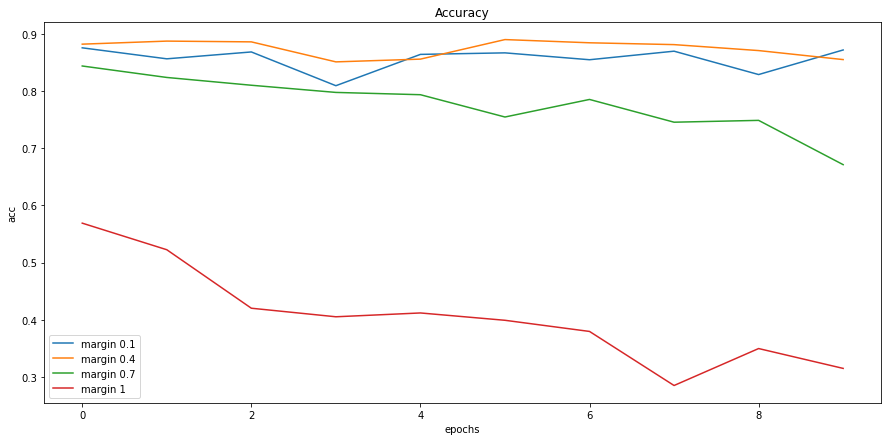

In [209]:
plt.figure(figsize=(15, 7))
plt.plot(accuracies[0], label='margin 0.1')
plt.plot(accuracies[1], label='margin 0.4')
plt.plot(accuracies[2], label='margin 0.7')
plt.plot(accuracies[3], label='margin 1')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.title('Accuracy')
plt.show()


### ArcFace Loss (Additive Angular Margin Loss) (25% points)

This loss is somewhat "SOTA" for face recognition systems (somewhat — because actually different variants of losses and their combinations may be the best for different network architectures). This loss inherits idea from CE loss but further develops it to achieve better embeddings distribution on a sphere. It introduces some geodesic constraints to enhance intra-class compactness and inter-class discrepancy.



**How ArcFace loss works**:

This loss is a variation of a standard SoftMax CE loss, which enforces embeddings of different classes (people) be further away: have a more sparse representation of embeddings in embedding space, enforce more evident gap between the nearest classes.

The standard SoftMax CE loss for classification task is presented as follows:

$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

where:
- $x_i \in \mathbb{R^d}$ denotes the deep feature of the $i$-th sample, belonging to the $y_i$-th class;
- $W_j \in \mathbb{R^d}$ denotes the j-th column of the weight;
- $W \in \mathbb{R^d}$ and $b_j \in \mathbb{R^d}$ is the bias term;
- $N$ — batch size;
- $n$ — class number.

It appears, that, though this loss works well, it does not explicitly optimise the feature embedding to enforce higher similarity for intra- class samples and diversity for inter-class samples, which results in a performance gap for deep face recognition under large intra-class appearance variations.

Let's do some work on this loss formula:
- fix the bias $b_j=0$;
- normalize weight ||$W_j$|| = 1;
- normalize embedding ||$x_i$|| = 1 and re-scale it to s (s is a hyperparameter)

The normalisation step on embeddings and weights makes the predictions only depend on the angle between the embedding and the weight. The learned embeddings fare thus distributed on a hypersphere with a radius of s.

So we get the following loss function now:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Final step: let's add an additive angular margin penalty $m$ between $x_i$ and $W_{y_i}$ to simultaneously enhance the intra-class compactness and inter-class discrepancy:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

SO this is an ArcFace loss. It has 2 hyperparameters: s and m.

The original paper to read about ArcFace more precisely: https://arxiv.org/pdf/1801.07698.pdf

The original repo, where you can find a code sample: https://github.com/deepinsight/insightface

**Task**: implement a model and train it with ArcFace loss. Play with ArcFace loss parameters and see if you can beat a model with CE loss.

To get the full mark for this task you need to train a model using TripletLoss correctly at least for one value of margin and achieve >=75% acc on test set.

In [7]:
def l2_norm(input,axis=1):
    norm = torch.norm(input,2,axis,True)
    output = torch.div(input, norm)
    return output

In [8]:
class Arcface(nn.Module):
    # implementation of additive margin softmax loss in https://arxiv.org/abs/1801.05599    
    def __init__(self, embedding_size=512, classnum=51332,  s=64., m=0.5):
        super(Arcface, self).__init__()
        self.classnum = classnum
        self.kernel = nn.Parameter(torch.Tensor(embedding_size,classnum))
        # initial kernel
        self.kernel.data.uniform_(-1, 1).renorm_(2,1,1e-5).mul_(1e5)
        self.m = m # the margin value, default is 0.5
        self.s = s # scalar value default is 64, see normface https://arxiv.org/abs/1704.06369
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.mm = self.sin_m * m  # issue 1
        self.threshold = math.cos(math.pi - m)
    def forward(self, embbedings, label):
        # weights norm
        nB = len(embbedings)
        kernel_norm = l2_norm(self.kernel,axis=0)
        # cos(theta+m)
        cos_theta = torch.mm(embbedings,kernel_norm)
#         output = torch.mm(embbedings,kernel_norm)
        cos_theta = cos_theta.clamp(-1,1) # for numerical stability
        cos_theta_2 = torch.pow(cos_theta, 2)
        sin_theta_2 = 1 - cos_theta_2
        sin_theta = torch.sqrt(sin_theta_2)
        cos_theta_m = (cos_theta * self.cos_m - sin_theta * self.sin_m)
        # this condition controls the theta+m should in range [0, pi]
        #      0<=theta+m<=pi
        #     -m<=theta<=pi-m
        cond_v = cos_theta - self.threshold
        cond_mask = cond_v <= 0
        keep_val = (cos_theta - self.mm) # when theta not in [0,pi], use cosface instead
        cos_theta_m[cond_mask] = keep_val[cond_mask]
        output = cos_theta * 1.0 # a little bit hacky way to prevent in_place operation on cos_theta
        idx_ = torch.arange(0, nB, dtype=torch.long)
        output[idx_, label] = cos_theta_m[idx_, label]
        output *= self.s # scale up in order to make softmax work, first introduced in normface
        return output

In [18]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [19]:
face_model = torch.load('./face_model_trained')
cropped_model = torch.nn.Sequential(*(list(face_model.children())[:-5]))
# cropped_model.bn = nn.BatchNorm2d(1792)

In [20]:
print(f'Count of children is: {len(list(cropped_model.children()))}')

Count of children is: 13


In [21]:
# Unfreezing layers all
for i, child in enumerate(cropped_model.children()):
    for param in child.parameters():
        param.requires_grad = True

In [22]:
# Freezing layers
kids_to_freeze = [x for x in range(12)]
for i, child in enumerate(cropped_model.children()):
    if i in kids_to_freeze:
        for param in child.parameters():
            param.requires_grad = False


In [23]:
for i, child in enumerate(cropped_model.children()):
    
    for param in child.parameters():
        print(i, param.requires_grad)


0 False
0 False
0 False
1 False
1 False
1 False
2 False
2 False
2 False
4 False
4 False
4 False
5 False
5 False
5 False
6 False
6 False
6 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
7 False
8 False
8 False
8 False
8 False
8 False
8 False
8 False


In [24]:
def train_arc(epochs=5, lr=0.0001, s=64, m=0.5):
    model = nn.DataParallel(cropped_model.to(device))
    criterion = nn.CrossEntropyLoss()
    arc = nn.DataParallel(Arcface(embedding_size=21504, classnum=1000, s=s, m=m).to(device))

    opt = Adam([{'params': model.parameters()},
               {'params': arc.parameters()}],
               lr=lr, weight_decay=5e-4    
              )    
    scheduler = lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)
    history = []    
    
    for epoch in range(epochs):
        print(f'Epoch {epoch} of {epochs} started')
        print('Epoch {}, lr {}'.format(epoch, opt.param_groups[0]['lr']))
        
        
        model.train()
        train_loss = []
        train_corrects = 0
        train_counter = 0
        
        
        # Training
        for data_trn in tqdm(train_loader):
            
            img = data_trn['image'].to(device)            
            labels = torch.tensor(list(map(int, data_trn['label']))).to(device)
            
            opt.zero_grad()
            
            embs = model(img).view(-1,1792*4*3) 
            thetas = arc(embs, labels)            
            loss = criterion(thetas, labels)
           
            loss.backward()
            opt.step()           
            
            preds = torch.argmax(thetas, 1)
            
            train_corrects += torch.sum(preds == labels.data)
            train_counter += len(labels)
            
#             if train_counter % (len(labels) * 25 ) == 0:                
#                 print(f'running_train_loss {loss}')
#                 print('Epoch {}, lr {}'.format(epoch, opt.param_groups[0]['lr']))
            train_loss.append(loss.detach().cpu())
    
        scheduler.step()
        
        train_LOSS = np.mean(train_loss)
        train_ACC = train_corrects.cpu().numpy() / train_counter
        
        
        print(f'train_loss {train_LOSS}  acc {train_ACC}')
        

            # Valing
        val_loss = []
        val_corrects = 0
        val_counter = 0    
        model.eval()

        for  data_val in tqdm(val_loader):
            img_ = data_val['image'].to(device)
            labels_ = torch.tensor(list(map(int, data_val['label']))).to(device)
            
            with torch.set_grad_enabled(False):                
                embs_ = model(img_).view(-1,1792*4*3)
                thetas_ = arc(embs_, labels_)
               
                loss_ = criterion(thetas_, labels_)
#                 if val_counter % (len(labels_) * 5 ) == 0:  
#                     print(f'val_running_loss {loss_}')
                preds_ = torch.argmax(thetas_, 1)
    
                val_loss.append(loss_.detach().cpu())
                val_corrects += torch.sum(preds_ == labels_.data)
                val_counter += len(labels_)

        val_LOSS = np.mean(val_loss)
        val_ACC = val_corrects.cpu().numpy() / val_counter   
        print(f'val_loss {val_LOSS}, val_ACC {val_ACC}')
        
        
        # Testing
        
        model.eval()
        with torch.no_grad():
            test_correct = 0
            test_counter = 0
            for data_test in tqdm(test_loader):
                
                labels__ = torch.tensor(list(map(int, data_test['label']))).to(device)
                img__ = data_test['image'].to(device)
                embs__ = model(img__).view(-1,1792*4*3)
                thetas__ = arc(embs__, labels__)
        
                preds__ = torch.argmax(thetas__, 1)
                test_correct += torch.sum(preds__ == labels__.data)
                test_counter += len(labels__)
            test_ACC = test_correct.cpu().numpy() / test_counter                 

            
        print(f'test_ACC {test_ACC}')
        history.append((train_LOSS, train_ACC, val_LOSS, val_ACC, test_ACC))
    torch.save(model, f'./arc_face_s{s}_m{m}')
    
    return history

    
    

In [25]:
# train_arc(epochs=4, s=44, m=3.5)

In [26]:
history = train_arc(epochs=4, s=44, m=3.5)

Epoch 0 of 4 started
Epoch 0, lr 0.0001


100%|████████████████████████████████████████████████████████████████████████████████| 267/267 [01:10<00:00,  3.79it/s]


train_loss 11.605286598205566  acc 0.7847752083577885


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.43it/s]


val_loss 4.302868843078613, val_ACC 0.8270877944325482


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.43it/s]


test_ACC 0.8289224952741021
Epoch 1 of 4 started
Epoch 1, lr 0.0001


100%|████████████████████████████████████████████████████████████████████████████████| 267/267 [01:10<00:00,  3.80it/s]


train_loss 2.8660359382629395  acc 0.9147200375630943


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.43it/s]


val_loss 0.01812310703098774, val_ACC 0.9991970021413277


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.43it/s]


test_ACC 0.9993698802772527
Epoch 2 of 4 started
Epoch 2, lr 0.0001


100%|████████████████████████████████████████████████████████████████████████████████| 267/267 [01:10<00:00,  3.80it/s]


train_loss 1.5333572626113892  acc 0.9592088273271511


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.44it/s]


val_loss 0.0077756368555128574, val_ACC 0.9991970021413277


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.39it/s]


test_ACC 0.999054820415879
Epoch 3 of 4 started
Epoch 3, lr 0.0001


100%|████████████████████████████████████████████████████████████████████████████████| 267/267 [01:10<00:00,  3.80it/s]


train_loss 0.5547472834587097  acc 0.9818053762178659


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.43it/s]


val_loss 5.9982809830216866e-09, val_ACC 1.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.43it/s]


test_ACC 1.0


In [27]:
# np.save('./history_arc_s44_m3_5.npy', history)

In [34]:
history

[(11.605287,
  0.7847752083577885,
  4.302869,
  0.8270877944325482,
  0.8289224952741021),
 (2.866036,
  0.9147200375630943,
  0.018123107,
  0.9991970021413277,
  0.9993698802772527),
 (1.5333573,
  0.9592088273271511,
  0.007775637,
  0.9991970021413277,
  0.999054820415879),
 (0.5547473, 0.9818053762178659, 5.998281e-09, 1.0, 1.0)]

In [37]:
train_loss, train_acc, val_loss, val_acc, test_acc = zip(*history)

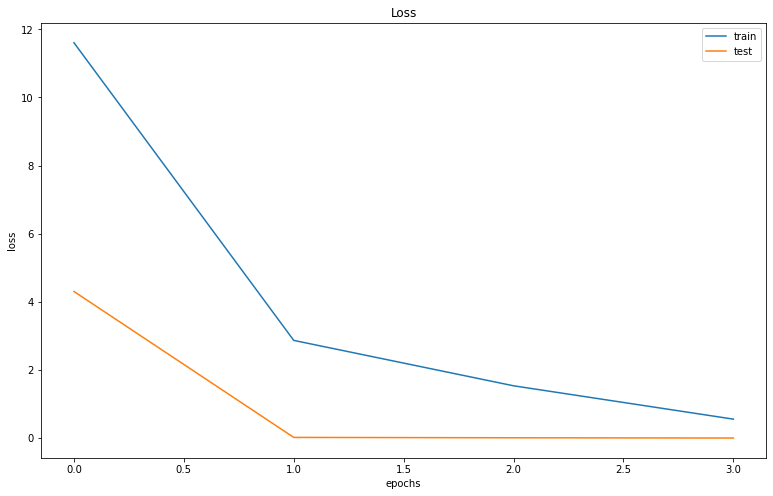

In [48]:
plt.figure(figsize=(13, 8))
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='test')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title('Loss')
plt.show()

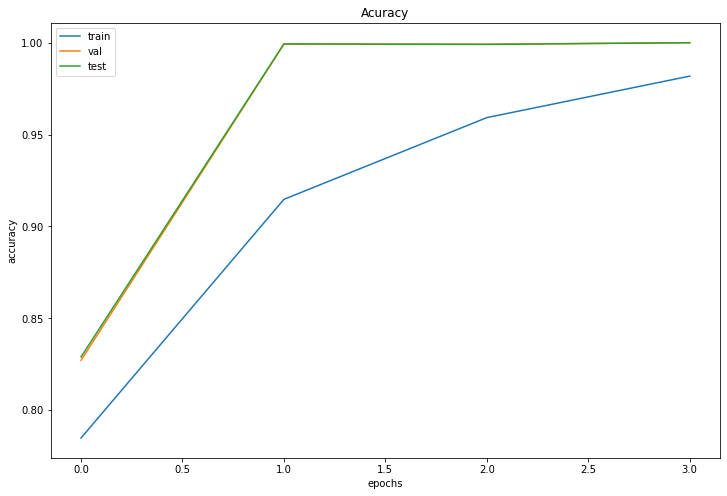

In [52]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.plot(test_acc, label='test')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title('Acuracy')
plt.show()

In [159]:
def get_embeddings_arc(model, loader):
    arc = Arcface(embedding_size=21504, classnum=1000, s=44, m=3.5).to(device)
    # Finding mean embedding vector for each person
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        d = {}  # Dict  
        for inputs in tqdm(loader):
            data = inputs['image'].to(device) #64 imgs
            labels = torch.tensor(list(map(int, inputs['label']))).to(device) # 64 lbls
            L = list(map(int, inputs['label']))
            
            outputs = model(data).view(-1,1792*4*3).to(device) 
            
            outputs = arc(outputs, labels)
#             print(outputs)
            tuples = list(zip(L, outputs)) # tuple (label, output)            
            
            # Making dict with embeddings
            for item in tuples:
                if item[0] in list(d.keys()):
                    d[item[0]].append(item[1].flatten())
                else:
                    d.update({item[0]: [item[1].flatten()]})
            torch.cuda.empty_cache()
                    
        # Mean embedding for each person            
        for key in d.keys():
            d[key] = sum(d[key]) / len(d[key])
            
    return d

In [142]:
from umap import UMAP

In [120]:
model_arc = torch.load('./arc_face_s44_m3.5')
model_arc

DataParallel(
  (module): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (2): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
 

In [160]:
arc_embs = get_embeddings_arc(model_arc, train_loader) # get main embeddings from arc_model

100%|████████████████████████████████████████████████████████████████████████████████| 267/267 [01:05<00:00,  4.09it/s]


In [243]:
def get_scatter(embs:dict, title:str):
    data = np.array([np.array(i.cpu()) for i in [embs[key] for key in embs.keys()]])
    targets = embs.keys()
    
    hyperbolic_mapper = UMAP(target_n_neighbors=1000, output_metric='hyperboloid',
                              random_state=42).fit(data)
    plt.figure(figsize=(12, 8))
    plt.scatter(hyperbolic_mapper.embedding_.T[0],
                hyperbolic_mapper.embedding_.T[1],
                c=list(targets), cmap='Spectral')
    plt.title(title)
    
    
    x = hyperbolic_mapper.embedding_[:, 0]
    y = hyperbolic_mapper.embedding_[:, 1]
    z = np.sqrt(1 + np.sum(hyperbolic_mapper.embedding_**2, axis=1))
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c=list(targets), cmap='Spectral')
    ax.view_init(35, 80)
    
    plt.show()

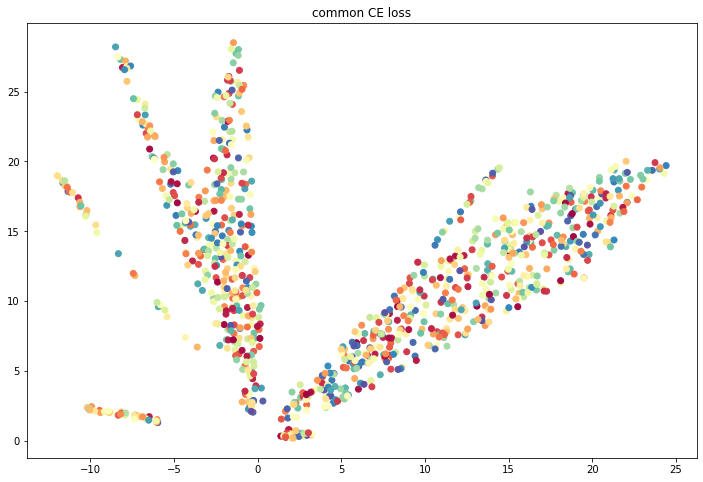

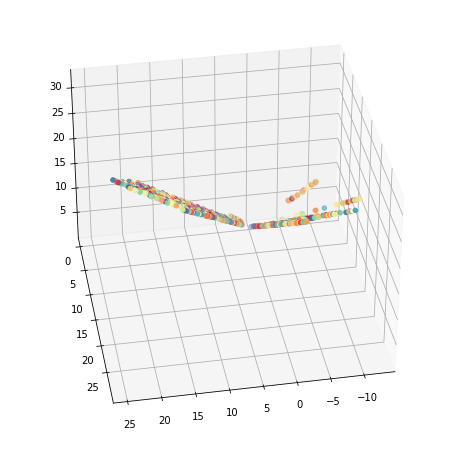

In [244]:
get_scatter(train_embeddings, 'common CE loss')

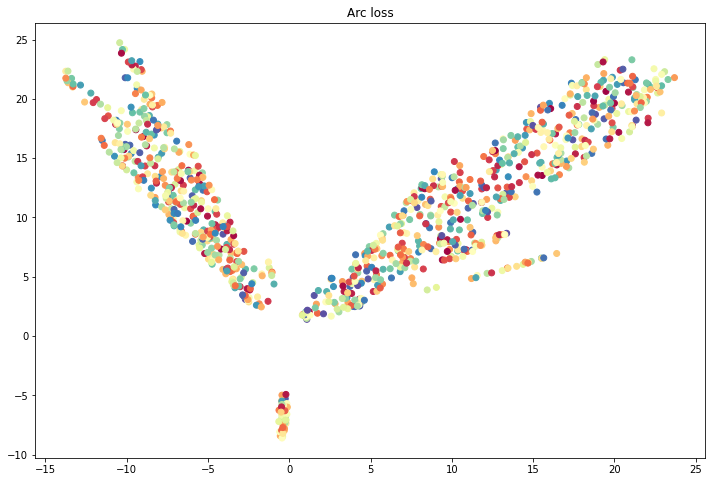

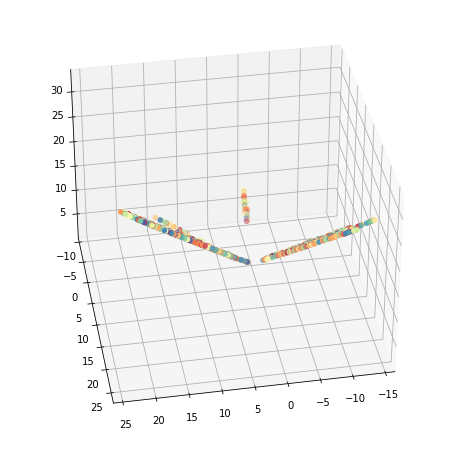

In [245]:
get_scatter(arc_embs, 'Arc loss')

In [270]:
d = np.array([np.array(i.cpu()) for i in [arc_embs[key] for key in arc_embs.keys()]])

In [271]:
target = np.array(list(arc_embs.keys()))

In [272]:
%%time
embedding = UMAP().fit_transform(X=d, y=target)

Wall time: 4.17 s


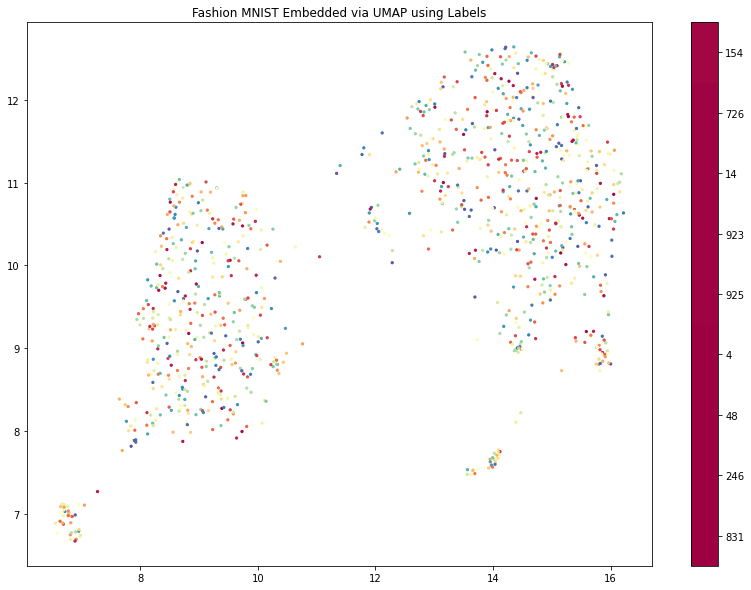

In [298]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=5, c=target, cmap='Spectral', alpha=1)
plt.setp(ax, xticks=[], yticks=[])
plt.yscale('linear')
plt.xscale('linear')
cbar = plt.colorbar(boundaries=np.arange(10)-0.5)
cbar.set_ticks(np.arange(999))
cbar.set_ticklabels(target)

plt.title('Fashion MNIST Embedded via UMAP using Labels');

#### I have grave doubts everything with this emplementation is Ok,and as we can see in plots there is some thing like overfitting. 
#### But CE record was beated.
#### There are 3 clearly visible groups. Perhaps male, female and trash photos

## Bonus task (5% points): Finding trash photos 

You have probably noticed that in identification rate calculation we use cosine similarity between embeddings, which includes embeddings' normalization. And in TripletLoss also we normalize embeddings before passing them to the loss. Actually this is how most of the face recognition algorithms work — they are designed to output a normalized embeddings and any comparison between embeddings is done after the embeddings are normalized. Sometimes it may be beneficial even to add a normalization layer (batchnorm or layernorm with fixed parameters) after the model's embedding layer to make the model output normalized embeddings.

But norms of the unnormalized embeddings can also be used. They can be used to detect trash photos — photos, where the face is presented really badly (e.g. back of the head instead of the forehead or even a photo without any head that has appeared in a dataset due to a mistake in face detection / landmarks detection algorithm).

Empirically it has been found that the higher the embedding's norm, the more the probability of the corresponding photo to be trash is. 



**Task**: get the embeddings of photos in a test set / query set / distractors set. Sort them by their norms. Output the photos whose embeddings norms are the highest. Do they look like normal or trash?

**Doing this task will not give you points above 100% for the whole homework. But if you have any mistakes in previous sections, doing this task may give you additional points (5% of total points) to cover points lost.**

In [ ]:
# YOUR CODE HERE

## What's next

What else can you do with this homework:
1. Try to train the network on faces which are aligned differently (or not aligned at all). The dataset can be downloaded here[link text](https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg?resourcekey=0-rJlzl934LzC-Xp28GeIBzQ)
2. Try to mix different losses while training. This often helps.
3. Try other losses from [this](https://arxiv.org/pdf/1901.05903.pdf) paper
4. Train bigger model on bigger dataset, as whole celebA, add [LFW](http://vis-www.cs.umass.edu/lfw/) and other
5. Explore embeddings spaces you get out of different models. How well are embeddings clasterized? Are they evenly spreaded on the sphere? How could you suggest to make it better?